In [126]:
# load libraries

import pandas as pd
from pandas import datetime
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.plotly as py
import plotly.graph_objs as go

import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error
from math import sqrt
import statsmodels.tsa.stattools as sts

from sklearn import preprocessing

from sklearn.model_selection import KFold, cross_val_score, GridSearchCV, train_test_split, TimeSeriesSplit 
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from statsmodels.tsa.vector_ar.vecm import coint_johansen

from pylab import rcParams #visual decomposition for time series

from datetime import datetime, timedelta

import warnings
import itertools
import pickle

import plotly.plotly as py
import plotly.graph_objs as go


%matplotlib inline
plt.style.use('fivethirtyeight')

**Approval Ratings**

In [2]:
dt_ratings = pd.read_pickle('dt_ratings.pickle')

In [3]:
dt_ratings.head()

,approve_estimate,disapprove_estimate,net_approval
modeldate,,,
2017-01-23,45.488977,41.088173,4.400803
2017-01-24,45.480880,41.541693,3.939187
2017-01-25,47.325433,43.027437,4.297997
2017-01-26,44.073550,40.696867,3.376683
2017-01-27,43.868173,41.279107,2.589067


**Master Data**

In [4]:
master_df = pd.read_pickle('dt_master.pickle')

In [5]:
master_df.head(10)

,net_approval,Price,compound,sentiment,trump_kw,trump_mueller_kw
2017-01-23,4.400803,19799.85,0.4939,0.0,100.0,0.0
2017-01-24,3.939187,19912.71,0.9753,0.0,100.0,0.0
2017-01-25,4.297997,20068.51,0.1605,3.0,100.0,0.0
2017-01-26,3.376683,20100.91,0.5197,3.0,100.0,0.0
2017-01-27,2.589067,20093.78,1.8175,1.0,100.0,0.0
2017-01-28,2.030490,19971.13,-0.4928,2.0,100.0,0.0
2017-01-29,1.911960,19971.13,-2.7618,5.0,100.0,0.0
2017-01-30,1.717383,19971.13,-1.0777,5.0,100.0,0.0
2017-01-31,0.922157,19864.09,0.0619,1.0,100.0,0.0
2017-02-01,0.237480,19890.94,1.2483,1.0,100.0,0.0


**Dow Jones Data**

In [6]:
djia_df = pd.read_pickle('djia_data.pickle')

In [7]:
djia_df['Change %'] = djia_df['Change %'].apply(lambda x: x.replace('%',''))

In [8]:
djia_df['Change %'] = djia_df['Change %'].astype(float)

In [9]:
djia_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 502 entries, 2019-01-18 to 2017-01-23
Data columns (total 6 columns):
Price       502 non-null float64
Open        502 non-null object
High        502 non-null object
Low         502 non-null object
Vol.        502 non-null float64
Change %    502 non-null float64
dtypes: float64(3), object(3)
memory usage: 27.5+ KB


In [69]:
djia_df.head(2)

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2019-01-18,24706.35,"24,534.19","24,750.22","24,459.03",372.97,1.38
2019-01-17,24370.10,"24,147.09","24,474.46","24,088.90",288.59,0.67


**Twitter Data**

In [11]:
dt_tweets = pd.read_pickle('dt_tweets.pickle')

In [12]:
dt_tweets.index = dt_tweets['date']

In [13]:
dt_tweets_df = dt_tweets.drop(['date', 'neg', 'neu', 'pos', 'sentiment','text'], axis=1)

In [14]:
dt_tweets_df = dt_tweets_df.groupby(dt_tweets_df.index).agg('mean')

In [15]:
dt_tweets_df.head(1)

,compound
date,
2017-01-23,0.4939


In [16]:
dt_tweets.head(10)

,text,date,neg,neu,pos,compound,sentiment
date,,,,,,,
2017-01-23,Busy week planned with a heavy focus on jobs a...,2017-01-23,0.000,0.826,0.174,0.4939,0
2017-01-24,Will be meeting at 9 00 with top automobile ex...,2017-01-24,0.000,0.876,0.124,0.2732,0
2017-01-24,A photo delivered yesterday that will be displ...,2017-01-24,0.118,0.749,0.134,0.0772,0
2017-01-24,Great meeting with automobile industry leaders...,2017-01-24,0.000,0.760,0.240,0.6249,0
2017-01-24,Signing orders to move forward with the constr...,2017-01-24,0.000,1.000,0.000,0.0000,0
2017-01-25,Great meeting with Ford CEO Mark Fields and Ge...,2017-01-25,0.000,0.785,0.215,0.6249,0
2017-01-25,Congratulations to for being number one in ina...,2017-01-25,0.138,0.577,0.285,0.4708,0
2017-01-25,If Chicago doesn t fix the horrible carnage go...,2017-01-25,0.258,0.742,0.000,-0.8402,1
2017-01-25,Big day planned on NATIONAL SECURITY tomorrow ...,2017-01-25,0.000,0.827,0.173,0.4824,0


In [17]:
djia_df.columns

Index(['Price', 'Open', 'High', 'Low', 'Vol.', 'Change %'], dtype='object')

**SPX Data**

In [219]:
spx = pd.read_csv('data/^GSPC _1719.csv')

In [220]:
spx["SPX"] = spx["Adj Close"].pct_change(1) 

In [221]:
spx = spx.dropna(axis=0)

In [222]:
spx = spx.drop(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], axis=1)

In [215]:
spx['Date'] = pd.to_datetime(spx['Date'])

In [224]:
spx = spx.set_index(spx['Date'], drop=True)

In [226]:
spx = spx.drop(['Date'], axis=1)

In [227]:
spx.head()

,SPX
Date,
1/24/17,0.006565
1/25/17,0.008026
1/26/17,-0.000735
1/27/17,-0.000866
1/30/17,-0.006010


**Make up and down df for graph**

In [73]:
djia_up = djia_df.where(djia_df['Change %']>=0)

In [75]:
djia_up = djia_up.dropna()

In [78]:
djia_down.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 218 entries, 2019-01-14 to 2017-01-23
Data columns (total 6 columns):
Price       218 non-null float64
Open        218 non-null object
High        218 non-null object
Low         218 non-null object
Vol.        218 non-null float64
Change %    218 non-null float64
dtypes: float64(3), object(3)
memory usage: 11.9+ KB


In [74]:
djia_down = djia_df.where(djia_df['Change %']<0)

In [76]:
djia_down = djia_down.dropna()

In [229]:
# Create a dataframe by merging the headlines and the stock prices dataframe
merged_dataframe = djia_df[['Price', 'Open', 'High', 'Low', 'Vol.', 'Change %']].merge(master_df)

ValueError: columns overlap but no suffix specified: Index(['Price'], dtype='object')

In [231]:
merged_dataframe = merged_dataframe.join(spx)

In [236]:
merged_dataframe['SPX'] = merged_dataframe['SPX'].fillna(method='backfill')

In [237]:
merged_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 726 entries, 2017-01-23 to 2019-01-18
Data columns (total 12 columns):
Price               726 non-null float64
Open                726 non-null object
High                726 non-null object
Low                 726 non-null object
Vol.                726 non-null float64
Change %            726 non-null float64
net_approval        726 non-null float64
compound            726 non-null float64
sentiment           726 non-null float64
trump_kw            726 non-null float64
trump_mueller_kw    726 non-null float64
SPX                 726 non-null float64
dtypes: float64(9), object(3)
memory usage: 93.7+ KB


In [238]:
merged_dataframe.index = master_df.index

In [239]:
merged_dataframe.tail()

,Price,Open,High,Low,Vol.,Change %,net_approval,compound,sentiment,trump_kw,trump_mueller_kw,SPX
2019-01-14,20093.78,"20,103.36","20,115.97","20,072.64",343.13,-0.04,2.589067,1.8175,1.0,10.0,0.0,-0.005258
2019-01-15,20100.91,"20,076.25","20,125.58","20,067.53",356.73,0.16,3.376683,0.5197,3.0,10.0,0.0,0.010722
2019-01-16,20068.51,"19,994.48","20,082.00","19,994.48",372.24,0.78,4.297997,0.1605,3.0,10.0,0.0,0.002222
2019-01-17,19912.71,"19,794.68","19,949.24","19,786.71",374.46,0.57,3.939187,0.9753,0.0,10.0,0.0,0.007591
2019-01-18,19799.85,"19,794.79","19,833.98","19,732.36",326.69,-0.14,4.400803,0.4939,0.0,10.0,0.0,0.013183


In [136]:
merged_dataframe['trump_kw'] = merged_dataframe['trump_kw'].apply(lambda x: x/10)
merged_dataframe['trump_mueller_kw'] = merged_dataframe['trump_mueller_kw'].apply(lambda x: x/10)

In [233]:
merged_dataframe.head()

,Price,Open,High,Low,Vol.,Change %,net_approval,compound,sentiment,trump_kw,trump_mueller_kw,SPX
2017-01-23,24706.35,"24,534.19","24,750.22","24,459.03",372.97,1.38,-14.905757,1.2601,4.0,3.4,5.6,NaN
2017-01-24,24370.10,"24,147.09","24,474.46","24,088.90",288.59,0.67,-14.991483,-1.0234,2.0,3.4,5.6,0.006565
2017-01-25,24207.16,"24,139.91","24,288.61","24,119.72",302.83,0.59,-14.453337,-0.7066,2.0,3.4,5.6,0.008026
2017-01-26,24065.59,"23,914.11","24,099.14","23,887.93",291.57,0.65,-13.448737,2.0999,6.0,3.4,5.6,-0.000735
2017-01-27,23909.84,"23,880.53","23,964.90","23,765.24",277.56,-0.36,-12.829610,-3.2650,9.0,3.7,5.2,-0.000866


In [22]:
merged_dataframe.columns

Index(['Price', 'Open', 'High', 'Low', 'Vol.', 'Change %', 'net_approval',
       'compound', 'sentiment', 'trump_kw', 'trump_mueller_kw'],
      dtype='object')

**Variables**

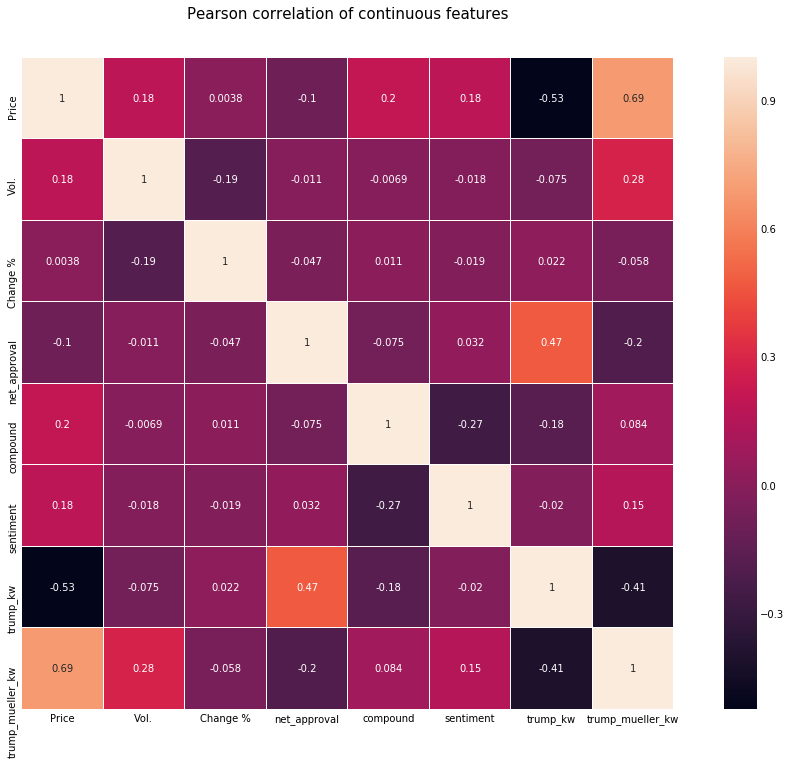

In [24]:
plt.figure(figsize=(16,12))
plt.title('Pearson correlation of continuous features', y=1.05, size=15)
sns.heatmap(merged_dataframe.corr(),linewidths=0.1,vmax=1.0, square=True, linecolor='white', annot=True)
plt.show()

### Convert Dataframes

In [25]:
#DJIA Price Data
djia_price = djia_df[['Price']].copy()

In [26]:
djia_percent = djia_df[['Change %']].copy()

In [27]:
djia_percent.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 502 entries, 2019-01-18 to 2017-01-23
Data columns (total 1 columns):
Change %    502 non-null float64
dtypes: float64(1)
memory usage: 7.8 KB


In [28]:
approvals = dt_ratings[['approve_estimate']].copy()

In [29]:
disapprovals = dt_ratings[['disapprove_estimate']].copy()

In [30]:
compound = dt_tweets[['compound']].copy()

**Full DataFrames**

In [31]:
djia_per_approvals = pd.DataFrame({"percent": djia_percent['Change %'], "approvals": approvals.approve_estimate})

In [32]:
full_data = pd.DataFrame({"percent": djia_df['Change %'], "approvals": approvals.approve_estimate, "disapprovals": disapprovals.disapprove_estimate, "trump_kw":master_df.trump_kw, "trump_mueller_kw":master_df.trump_mueller_kw})

In [33]:
#full_data['compound'] = compound.compound

In [34]:
#full_data['percent'] = full_data['percent'].apply(lambda x: x.replace('%',''))

In [35]:
#save dataframe as pickle file

with open('full_data.pickle', 'wb') as to_write:
    pickle.dump(full_data, to_write)

In [36]:
full_data['percent'] = full_data['percent'].fillna(method='bfill')

In [37]:
#full_data['compound'] = dt_tweets[['compound']].copy()

In [38]:
full_data.head(1)

,percent,approvals,disapprovals,trump_kw,trump_mueller_kw
modeldate,,,,,
2017-01-23,-0.14,45.488977,41.088173,100.0,0.0


In [39]:
percent = full_data[['percent']].copy()

In [40]:
variables = full_data.drop(['percent'], axis=1)

In [41]:
variables = variables.drop(['disapprovals'], axis=1)

In [42]:
variables.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 726 entries, 2017-01-23 to 2019-01-18
Freq: D
Data columns (total 3 columns):
approvals           726 non-null float64
trump_kw            726 non-null float64
trump_mueller_kw    726 non-null float64
dtypes: float64(3)
memory usage: 22.7 KB


## Split Data

In [240]:
train_full = full_data[:int(0.8*(len(djia_df)))]
test_full = full_data[int(0.8*(len(djia_df))):]

# Recheck the count
print(merged_dataframe.count())
# Separate the dataframe for input(X) and output variables(y)
X = merged_dataframe[['net_approval','compound', 'sentiment', 'trump_kw', 'trump_mueller_kw']]
y = merged_dataframe['Change %']
y1 = merged_dataframe['SPX']

# Split the dataset to test and train sets
# Split the initial 70% of the data as training set and the remaining 30% data as the testing set
train_size = int(len(X) * 0.8)
print(len(y))
print(train_size)

#X_train, X_test = X[:int(0.8*(len(merged_dataframe)))], X[int(0.8*(len(merged_dataframe))):]
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
y1_train, y1_test = y1[:train_size], y1[train_size:]

Price               726
Open                726
High                726
Low                 726
Vol.                726
Change %            726
net_approval        726
compound            726
sentiment           726
trump_kw            726
trump_mueller_kw    726
SPX                 726
dtype: int64
726
580


In [60]:
X_test.tail()

,net_approval,compound,sentiment,trump_kw,trump_mueller_kw
2019-01-14,2.589067,1.8175,1.0,100.0,0.0
2019-01-15,3.376683,0.5197,3.0,100.0,0.0
2019-01-16,4.297997,0.1605,3.0,100.0,0.0
2019-01-17,3.939187,0.9753,0.0,100.0,0.0
2019-01-18,4.400803,0.4939,0.0,100.0,0.0


## Stationarize 

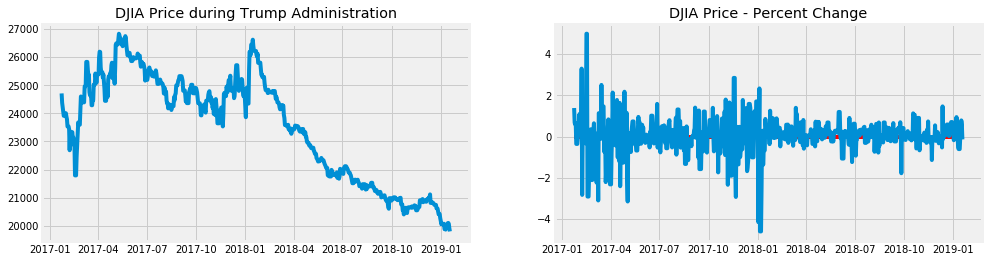

In [44]:
# Graph data
fig, axes = plt.subplots(1, 2, figsize=(15,4))

# Levels
axes[0].plot(master_df.index._mpl_repr(), merged_dataframe.Price, '-')
axes[0].set(title='DJIA Price during Trump Administration')

# Log difference
axes[1].plot(merged_dataframe.index._mpl_repr(),merged_dataframe['Change %'] , '-')
axes[1].hlines(0, master_df.index[0], master_df.index[-1], colors='r')
axes[1].set(title='DJIA Price - Percent Change');

**Testing Stationarity**

In [45]:
# define Dickey-Fuller Test (DFT) function
import statsmodels.tsa.stattools as ts
def dftest(timeseries):
    dftest = ts.adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','Lags Used','Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    #Determine rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)

Test Statistic         -1.097383e+01
p-value                 7.759297e-20
Lags Used               5.000000e+00
Observations Used       7.200000e+02
Critical Value (1%)    -3.439465e+00
Critical Value (5%)    -2.865563e+00
Critical Value (10%)   -2.568912e+00
dtype: float64


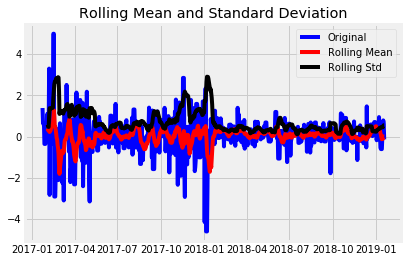

In [46]:
dftest(merged_dataframe['Change %'])
#Data stationary

## Autocorrelation 

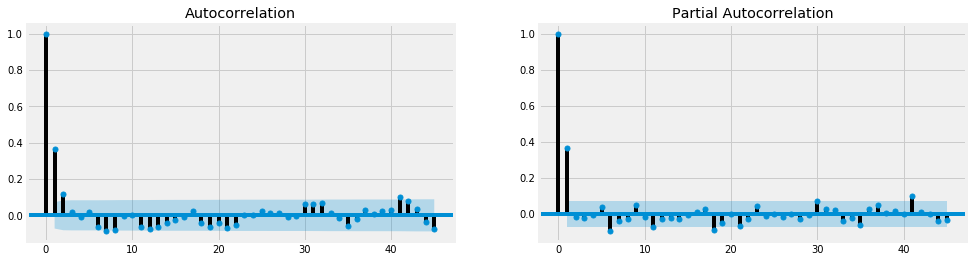

In [47]:
fig, axes = plt.subplots(1, 2, figsize=(15,4))

fig = sm.graphics.tsa.plot_acf(merged_dataframe.iloc[1:]['Change %'], lags=45, ax=axes[0])
fig = sm.graphics.tsa.plot_pacf(merged_dataframe.iloc[1:]['Change %'], lags=45, ax=axes[1])

## Model Building

### Model (DJIA - % Change in Price)

**Grid Search**

In [48]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))


Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [49]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1930.9967496005152
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1903.5737163876543
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:2450.7420990032956
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1881.198966956644
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1907.0503779229766
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1888.7278996574278
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:2147.1744013051366
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1907.5318824400538
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1836.1236193519435
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:1811.886547180682
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:2335.8309106158026
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1770.1477135403588
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1818.4619319519616
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:1792.1201015448373
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:2055.7222410887216
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:1797.1459610374693
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:2098.874305332448
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:2075.774554142

**AR Model**

In [50]:
mod_ar = sm.tsa.statespace.SARIMAX(y_train, order=(1,0,0),seasonal_order=(0,0,0,12)).fit()
mod_ar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:               Change %   No. Observations:                  580
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -779.786
Date:                Wed, 30 Jan 2019   AIC                           1563.571
Time:                        16:18:05   BIC                           1572.297
Sample:                    01-23-2017   HQIC                          1566.973
                         - 08-25-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3712      0.019     19.273      0.000       0.333       0.409
sigma2         0.8614      0.026     32.965      0.000       0.810       0.913
===================================================================================
Ljung-Box (Q):                       36.67   Jarque-Bera (JB):              1095.05
Prob(Q):                              0.62   Prob(JB):                         0.00
Heteroskedasticity (H):               0.13   Skew:                            -0.86
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

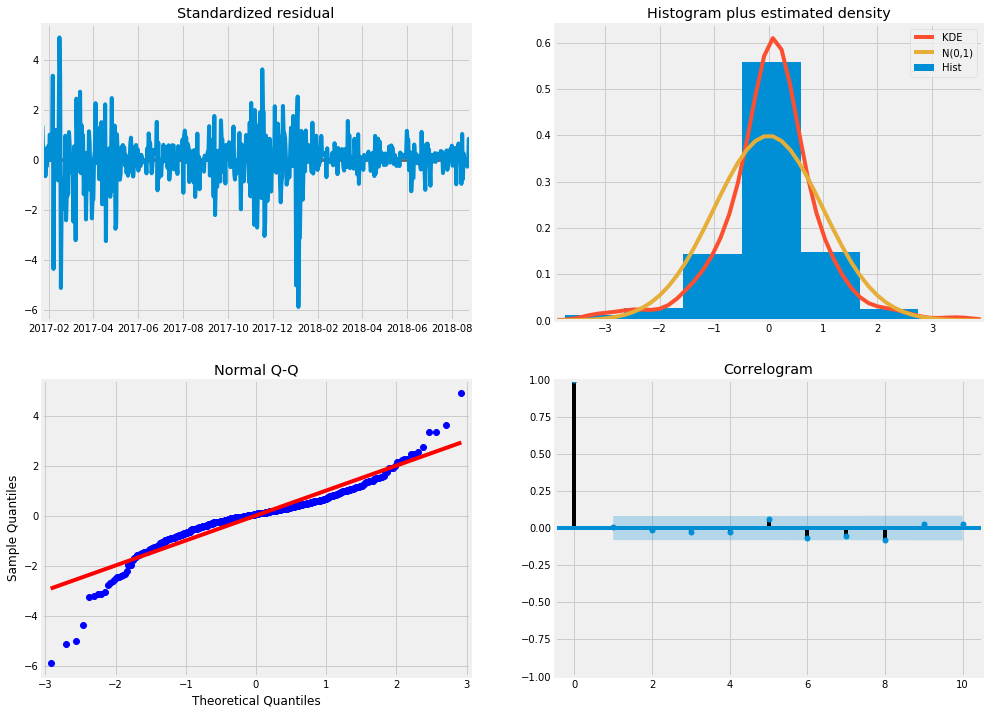

In [51]:
mod_ar.plot_diagnostics(figsize=(15, 12))
plt.show()

In [52]:
forecast = mod_ar.forecast(steps = 146)

In [53]:
sm.tools.eval_measures.rmse(y_test, forecast)

#0.44955843807974216

0.44955843807974216

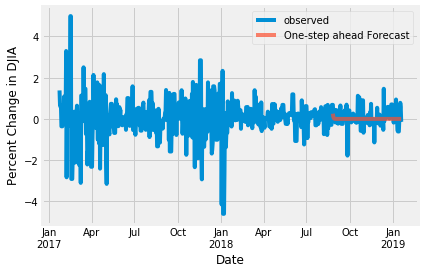

In [54]:
ax = y.plot(label='observed')
forecast.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.set_xlabel('Date')
ax.set_ylabel('Percent Change in DJIA')
plt.legend()

plt.show()

### Model (with Exogenous Variables)

In [134]:
sc = StandardScaler()

In [197]:
mod_arx = sm.tsa.statespace.SARIMAX(y_train, X_train.iloc[:, [1,2,4]], order=(1,0,0), seasonal_order=(0,0,0,12), enforce_stationarity=True, enforce_invertibility=True).fit()
mod_arx.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:               Change %   No. Observations:                  580
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -779.477
Date:                Wed, 30 Jan 2019   AIC                           1568.953
Time:                        20:44:38   BIC                           1590.768
Sample:                    01-23-2017   HQIC                          1577.458
                         - 08-25-2018                                         
Covariance Type:                  opg                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
compound             0.0122      0.017      0.723      0.470      -0.021       0.045
sentiment            0.0019      0.017      0.109      0.913      -0.032       0.036
trump_mueller_kw    -0.0006      0.001     -0.413      0.680      -0.003       0.002
ar.L1                0.3710      0.020     18.667      0.000       0.332       0.410
sigma2               0.8605      0.027     31.815      0.000       0.807       0.913
===================================================================================
Ljung-Box (Q):                       36.82   Jarque-Bera (JB):              1095.38
Prob(Q):                              0.61   Prob(JB):                         0.00
Heteroskedasticity (H):               0.13   Skew:                            -0.86
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

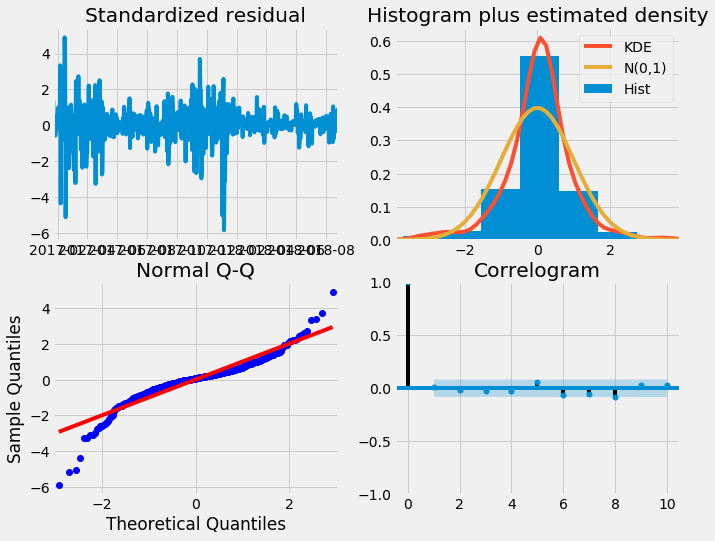

In [198]:
mod_arx.plot_diagnostics(figsize=(10, 8));

In [199]:
yhat = mod_arx.predict(start=pd.to_datetime('2018-08-26'), end=pd.to_datetime('2019-01-18'), exog=X_test.iloc[:, [1,2,4]])

In [200]:
sm.tools.eval_measures.rmse(y_test, yhat)
# RMSE = 0.5136699243597855

0.4476347978290576

In [323]:
data = [
    go.Bar(
        x = djia_up.index,
        y = djia_up['Change %'],
        marker = dict(
          color = 'green'
        ),
        name = 'up'
    ),
    go.Bar(
        x = djia_down.index,
        y = djia_down['Change %'],
        marker = dict(
          color = 'red'
        ),
        name = 'down'
    ),
    go.Scatter(
        x = merged_dataframe.index,
        y = merged_dataframe['net_approval'],
        marker = dict(
          color = 'blue'
        ),
        name = 'Net Approval Rating'
    )
]

layout = go.Layout(
    title='Dow Jones Returns',
    xaxis=dict(
        title='Dates',
        titlefont=dict(
            family='Open Sans',
            size=16,
            color='#7f7f7f'
        )
    ),
    yaxis=dict(
        title='Percent Change in Close (%)',
        titlefont=dict(
            family='Open Sans',
            size=16,
            color='#7f7f7f'
        )
    )
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='djia-bar')

In [124]:
data = [
    go.Scatter(
        x = merged_dataframe.index,
        y = merged_dataframe['net_approval'],
        marker = dict(
          color = 'blue'
        ),
        name = 'down'
    )
]


fig = go.Figure(data=data)
py.iplot(fig, filename='variable-bar')

In [102]:
data = [
    go.Scatter(
        x = merged_dataframe.index,
        y = merged_dataframe['trump_kw'],
        marker = dict(
          color = 'blue'
        ),
        name = 'down'
    )
]


fig = go.Figure(data=data)
py.iplot(fig, filename='trump-bar')

In [104]:
data = [
    go.Scatter(
        x = merged_dataframe.index,
        y = merged_dataframe['trump_mueller_kw'],
        marker = dict(
          color = 'blue'
        ),
        name = 'down'
    )
]


fig = go.Figure(data=data)
py.iplot(fig, filename='trumpm-bar')

In [100]:
data = [
    go.Bar(
        x = merged_dataframe.index,
        y = merged_dataframe['compound'],
        marker = dict(
          color = 'blue'
        ),
        name = 'down'
    )
]


fig = go.Figure(data=data)
py.iplot(fig, filename='compound-bar')

In [115]:
#Granger Causality Test

sts.grangercausalitytests(merged_dataframe.iloc[:, [5,6]], maxlag = 15, addconst=True, verbose=True)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8597  , p=0.3541  , df_denom=722, df_num=1
ssr based chi2 test:   chi2=0.8633  , p=0.3528  , df=1
likelihood ratio test: chi2=0.8627  , p=0.3530  , df=1
parameter F test:         F=0.8597  , p=0.3541  , df_denom=722, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.8484  , p=0.4285  , df_denom=719, df_num=2
ssr based chi2 test:   chi2=1.7086  , p=0.4256  , df=2
likelihood ratio test: chi2=1.7066  , p=0.4260  , df=2
parameter F test:         F=0.8484  , p=0.4285  , df_denom=719, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.7523  , p=0.5212  , df_denom=716, df_num=3
ssr based chi2 test:   chi2=2.2790  , p=0.5166  , df=3
likelihood ratio test: chi2=2.2754  , p=0.5172  , df=3
parameter F test:         F=0.7523  , p=0.5212  , df_denom=716, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.9282  , p=0.4469  

{1: ({'ssr_ftest': (0.8596876322724886, 0.3541359562740517, 722.0, 1),
   'ssr_chi2test': (0.863259741547859, 0.35282808105521324, 1),
   'lrtest': (0.862746206131078, 0.35297132478297333, 1),
   'params_ftest': (0.8596876322722811, 0.35413595627409655, 722.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (0.8483830697131035, 0.42853468742710177, 719.0, 2),
   'ssr_chi2test': (1.708565625792175, 0.4255883081023467, 2),
   'lrtest': (1.7065527722413663, 0.4260168471813496, 2),
   'params_ftest': (0.8483830697131562, 0.42853468742708467, 719.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (0.7523146151513879, 0.5212029902807385, 716.0, 3),
   'ssr_chi2test': (2.279008938915308, 0.5165541602898358, 3),
   'lrtest': (2.2754245731723586, 0.5172452480947831, 3),
   'params_ftest': (0.7523146151513859, 0.5212029902807385, 716.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0.,

In [116]:
sts.grangercausalitytests(merged_dataframe.iloc[:, [6,5]], maxlag = 15, addconst=True, verbose=True)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4365  , p=0.5090  , df_denom=722, df_num=1
ssr based chi2 test:   chi2=0.4383  , p=0.5079  , df=1
likelihood ratio test: chi2=0.4382  , p=0.5080  , df=1
parameter F test:         F=0.4365  , p=0.5090  , df_denom=722, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.9903  , p=0.1374  , df_denom=719, df_num=2
ssr based chi2 test:   chi2=4.0082  , p=0.1348  , df=2
likelihood ratio test: chi2=3.9972  , p=0.1355  , df=2
parameter F test:         F=1.9903  , p=0.1374  , df_denom=719, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.7093  , p=0.1637  , df_denom=716, df_num=3
ssr based chi2 test:   chi2=5.1779  , p=0.1592  , df=3
likelihood ratio test: chi2=5.1595  , p=0.1605  , df=3
parameter F test:         F=1.7093  , p=0.1637  , df_denom=716, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.3734  , p=0.2415  

{1: ({'ssr_ftest': (0.4365119411300292, 0.5090215584176223, 722.0, 1),
   'ssr_chi2test': (0.43832570265827037, 0.5079316763171502, 1),
   'lrtest': (0.43819325299068623, 0.5079957867110543, 1),
   'params_ftest': (0.4365119411296934, 0.5090215584177782, 722.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (1.9902811105597977, 0.13740919008790575, 719.0, 2),
   'ssr_chi2test': (4.008243460487604, 0.13477861571141608, 2),
   'lrtest': (3.9971889274752357, 0.1355256356270379, 2),
   'params_ftest': (1.9902811105597125, 0.13740919008792557, 719.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (1.7092649762465997, 0.1637013960700997, 716.0, 3),
   'ssr_chi2test': (5.177927002065467, 0.1592225609434538, 3),
   'lrtest': (5.159473611077601, 0.16048528600782347, 3),
   'params_ftest': (1.7092649762466372, 0.16370139607009568, 716.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 

In [140]:
sts.grangercausalitytests(merged_dataframe.iloc[:, [10,5]], maxlag = 20, addconst=True, verbose=True)
#Look at 14 days


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4861  , p=0.4859  , df_denom=722, df_num=1
ssr based chi2 test:   chi2=0.4881  , p=0.4848  , df=1
likelihood ratio test: chi2=0.4879  , p=0.4848  , df=1
parameter F test:         F=0.4861  , p=0.4859  , df_denom=722, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.3400  , p=0.7119  , df_denom=719, df_num=2
ssr based chi2 test:   chi2=0.6848  , p=0.7101  , df=2
likelihood ratio test: chi2=0.6845  , p=0.7102  , df=2
parameter F test:         F=0.3400  , p=0.7119  , df_denom=719, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.8965  , p=0.4426  , df_denom=716, df_num=3
ssr based chi2 test:   chi2=2.7157  , p=0.4376  , df=3
likelihood ratio test: chi2=2.7107  , p=0.4384  , df=3
parameter F test:         F=0.8965  , p=0.4426  , df_denom=716, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.0755  , p=0.3676  

{1: ({'ssr_ftest': (0.48607998617304266, 0.48590558989556076, 722.0, 1),
   'ssr_chi2test': (0.4880997091072796, 0.484776207404775, 1),
   'lrtest': (0.4879354784516181, 0.4848496883748413, 1),
   'params_ftest': (0.4860799861730315, 0.48590558989556076, 722.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (0.34003196802838737, 0.7118619617860773, 719.0, 2),
   'ssr_chi2test': (0.6847931706607857, 0.7100665468860907, 2),
   'lrtest': (0.6844695199715716, 0.7101814629476494, 2),
   'params_ftest': (0.340031968028381, 0.7118619617860773, 719.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (0.8964844132005998, 0.4425625914369259, 716.0, 3),
   'ssr_chi2test': (2.7157467768604757, 0.4375579240766735, 3),
   'lrtest': (2.7106590426647017, 0.4384189398462591, 3),
   'params_ftest': (0.8964844132006339, 0.4425625914369109, 716.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0.

In [139]:
sts.grangercausalitytests(merged_dataframe.iloc[:, [5,10]], maxlag = 20, addconst=True, verbose=True)
#Look at 14 days


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7128  , p=0.3988  , df_denom=722, df_num=1
ssr based chi2 test:   chi2=0.7157  , p=0.3975  , df=1
likelihood ratio test: chi2=0.7154  , p=0.3977  , df=1
parameter F test:         F=0.7128  , p=0.3988  , df_denom=722, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.5232  , p=0.5929  , df_denom=719, df_num=2
ssr based chi2 test:   chi2=1.0536  , p=0.5905  , df=2
likelihood ratio test: chi2=1.0528  , p=0.5907  , df=2
parameter F test:         F=0.5232  , p=0.5929  , df_denom=719, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.3987  , p=0.7540  , df_denom=716, df_num=3
ssr based chi2 test:   chi2=1.2078  , p=0.7511  , df=3
likelihood ratio test: chi2=1.2068  , p=0.7514  , df=3
parameter F test:         F=0.3987  , p=0.7540  , df_denom=716, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.3130  , p=0.8694  

{1: ({'ssr_ftest': (0.7127871589634343, 0.39879974215983593, 722.0, 1),
   'ssr_chi2test': (0.7157488784605123, 0.3975419043320645, 1),
   'lrtest': (0.7153958029198293, 0.3976583347273742, 1),
   'params_ftest': (0.7127871589632596, 0.3987997421598889, 722.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (0.5231662091495278, 0.5928665743116328, 719.0, 2),
   'ssr_chi2test': (1.0536087216251966, 0.5904889474386562, 2),
   'lrtest': (1.052842826921733, 0.5907151169200429, 2),
   'params_ftest': (0.5231662091495524, 0.5928665743116092, 719.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (0.39869308879975385, 0.7539841563451715, 716.0, 3),
   'ssr_chi2test': (1.20777277878026, 0.7511406882843445, 3),
   'lrtest': (1.206765107553565, 0.7513822209150733, 3),
   'params_ftest': (0.3986930887997506, 0.7539841563451715, 716.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0., 0.

# SPX

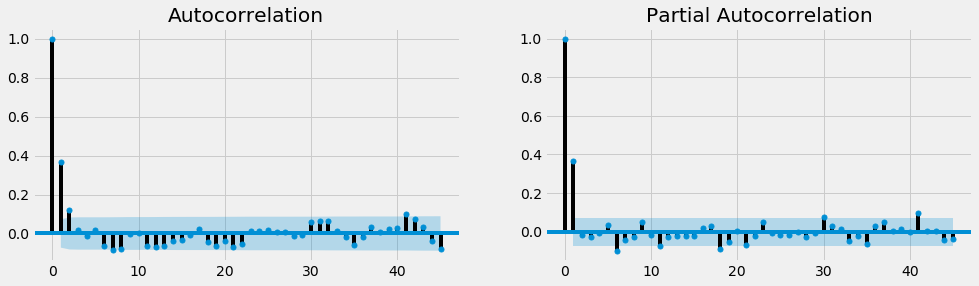

In [275]:
fig, axes = plt.subplots(1, 2, figsize=(15,4))

fig = sm.graphics.tsa.plot_acf(merged_dataframe.iloc[:-1]['Change %'], lags=45, ax=axes[0])
fig = sm.graphics.tsa.plot_pacf(merged_dataframe.iloc[:-1]['Change %'], lags=45, ax=axes[1])

In [320]:
mod_spx = sm.tsa.statespace.SARIMAX(y1_train, order=(1,0,0),seasonal_order=(0,0,0,12)).fit()
mod_spx.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                    SPX   No. Observations:                  580
Model:               SARIMAX(1, 0, 0)   Log Likelihood                2073.135
Date:                Wed, 30 Jan 2019   AIC                          -4142.270
Time:                        21:43:29   BIC                          -4133.544
Sample:                    01-23-2017   HQIC                         -4138.868
                         - 08-25-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3531      0.016     22.698      0.000       0.323       0.384
sigma2        4.6e-05   1.36e-06     33.810      0.000    4.33e-05    4.87e-05
===================================================================================
Ljung-Box (Q):                       55.39   Jarque-Bera (JB):               956.52
Prob(Q):                              0.05   Prob(JB):                         0.00
Heteroskedasticity (H):               3.77   Skew:                            -0.55
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

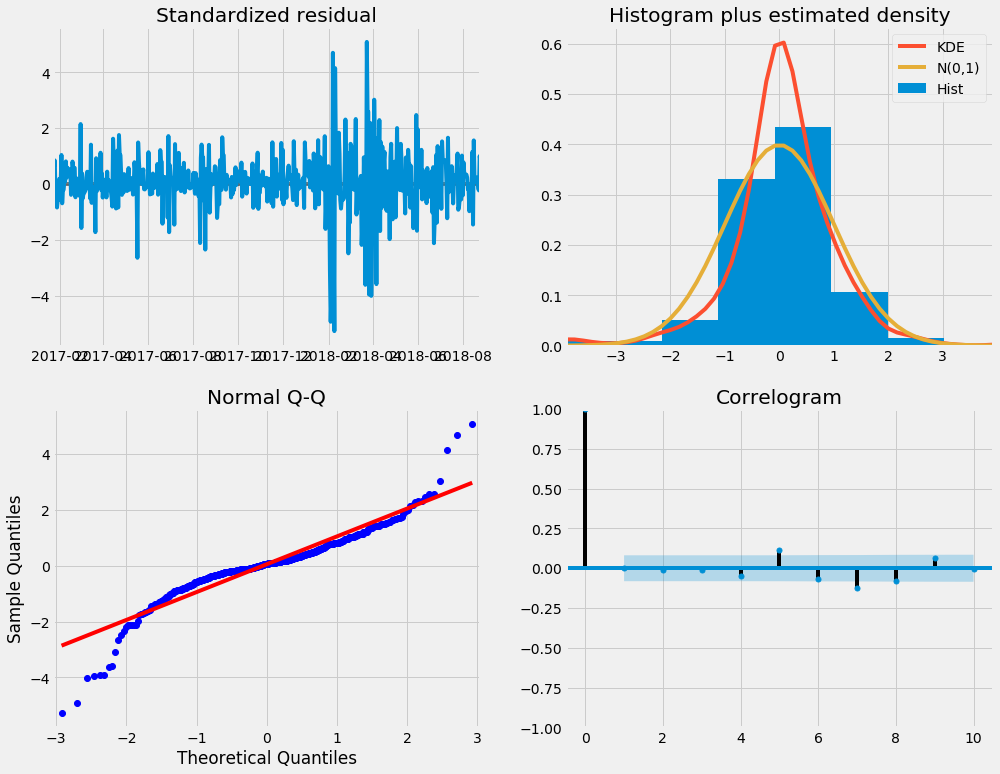

In [321]:
mod_spx.plot_diagnostics(figsize=(15, 12))
plt.show()

In [322]:
forecast = mod_spx.forecast(steps = 146)

In [319]:
sm.tools.eval_measures.rmse(y1_test, forecast)

0.01295273079619144

## Exogenous Variable

In [295]:
mod_spxx = sm.tsa.statespace.SARIMAX(y1_train, X_train.iloc[:, [1,2,4]], order=(1,0,0), seasonal_order=(0,0,0,12), enforce_stationarity=True, enforce_invertibility=True).fit()
mod_spxx.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                    SPX   No. Observations:                  580
Model:               SARIMAX(1, 0, 0)   Log Likelihood                2074.275
Date:                Wed, 30 Jan 2019   AIC                          -4138.549
Time:                        21:42:16   BIC                          -4116.734
Sample:                    01-23-2017   HQIC                         -4130.044
                         - 08-25-2018                                         
Covariance Type:                  opg                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
compound          2.204e-05      0.000      0.157      0.876      -0.000       0.000
sentiment        -6.343e-05      0.000     -0.434      0.664      -0.000       0.000
trump_mueller_kw     0.0001      0.000      1.107      0.268      -0.000       0.000
ar.L1                0.3449      0.016     21.454      0.000       0.313       0.376
sigma2            4.576e-05    1.4e-06     32.793      0.000     4.3e-05    4.85e-05
===================================================================================
Ljung-Box (Q):                       55.40   Jarque-Bera (JB):               972.87
Prob(Q):                              0.05   Prob(JB):                         0.00
Heteroskedasticity (H):               3.83   Skew:                            -0.57
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

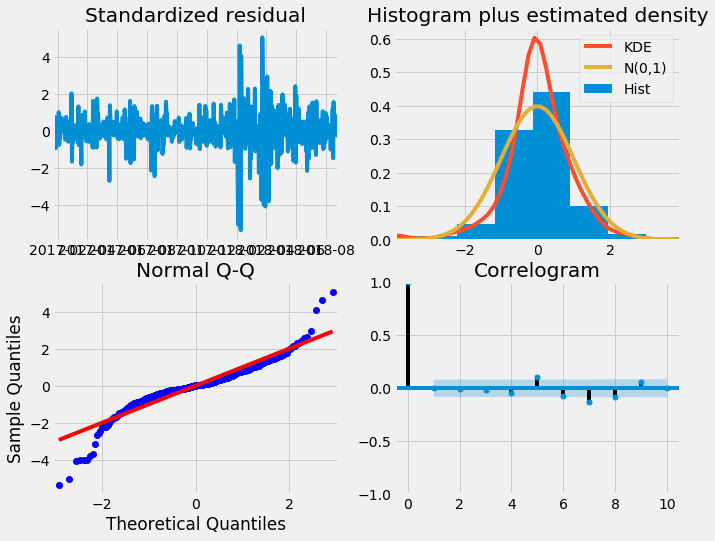

In [296]:
mod_spxx.plot_diagnostics(figsize=(10, 8));

In [297]:
yhat_spxx = mod_spxx.predict(start=pd.to_datetime('2018-08-26'), end=pd.to_datetime('2019-01-18'), exog=X_test.iloc[:, [1,2,4]])

In [298]:
sm.tools.eval_measures.rmse(y_test, yhat_spxx)

0.4517700972875529